### Trip Advisor Hotel Reviews
https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

In [47]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [48]:
df = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')

In [49]:
df.columns

Index(['Review', 'Rating'], dtype='object')

In [50]:
def standardize_text(df, field):
    df[field] = df[field].str.replace(r"http\S+", "")
    df[field] = df[field].str.replace(r"http","")
    df[field] = df[field].str.replace(r"@/S+","")
    df[field] = df[field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.lower()
    return df

In [51]:
data = standardize_text(df,"Review")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [52]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
labels = [i - 1 for i in df['Rating'].values]

In [54]:
lemmatizer = WordNetLemmatizer()
texts = []
for i in tqdm(range(0, len(df))):
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    texts.append(review)

100%|██████████| 20491/20491 [04:43<00:00, 72.40it/s] 


In [55]:
data = pd.DataFrame()

data['text'] = texts
data['label'] = labels

In [56]:
train, test = train_test_split(data, test_size=0.2)

### TF-IDF

In [57]:
vectorizer = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS)

In [58]:
vectorizer.fit(train['text'].values)

TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [59]:
X_train = vectorizer.transform(train['text'].values)
y_train = train['label'].values

X_test = vectorizer.transform(test['text'].values)
y_test = test['label'].values

### LR

In [60]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear')

clf.fit(X_train, y_train)

predictions = clf.predict(X_train)
predictions_test = clf.predict(X_test)

print('acc', accuracy_score(predictions,y_train))
print('f1', f1_score(predictions, y_train, average='macro'))
print('acc', accuracy_score(predictions_test, y_test))
print('f1', f1_score(predictions_test, y_test, average='macro'))

acc 0.7565885797950219
f1 0.722285537717244
acc 0.616247865333008
f1 0.5286213873451862


### 

### LSTM

In [61]:
pip install transformers sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [62]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [63]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()

tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

In [64]:
texts = train['text'].values

In [65]:
with open('texts.txt', 'w') as f:
    for text in texts:
        f.write("%s\n" % text)

In [66]:
tokenizer.train(
    files=['./texts.txt'],
    vocab_size=3_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

In [67]:
tokenizer.save('tokenizer.json')

In [68]:
tokens_list = [tokenizer.encode(text).ids for text in texts]

In [69]:
len_list = [len(tokens) for tokens in tokens_list]

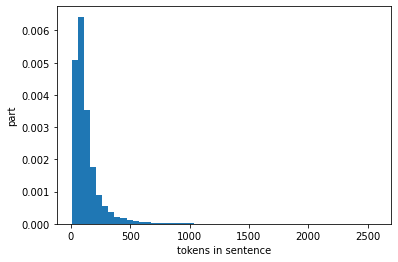

In [70]:
plt.hist(len_list, density=True, bins=50)
plt.ylabel('part')
plt.xlabel('tokens in sentence');

In [71]:
max_len = 128

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(label)
        tokens = self.tokens[idx]
        out = torch.zeros(max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:max_len]
        return out, label

In [73]:
# class imbalance
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

y_train = train['label'].values

counts = np.bincount(y_train.astype(int))
labels_weights = 1. / counts
weights = labels_weights[y_train.astype(int)]
sampler = WeightedRandomSampler(weights, len(weights))

In [74]:
train_texts = train['text'].values
train_ids = [tokenizer.encode(text).ids for text in train_texts]
train_labels = list(train['label'])
train_dataset = CustomDataset(train_ids, train_labels, max_len)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=20, shuffle=False)

In [75]:
test_texts =test['text'].values
test_ids = [tokenizer.encode(text).ids for text in test_texts]
test_labels = list(test['label'])
test_dataset = CustomDataset(test_ids, test_labels, max_len)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [76]:
class NeuralNetwork(nn.Module):


    def __init__(self, hidden_dim=256, vocab_size=3000, embedding_dim=300, linear_dim=256, dropout=0.1, n_classes=5):
        super(NeuralNetwork, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
        return out

In [77]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [79]:
def train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=10):
    best_score = 0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            loss = loss_function(predict, labels)
            loss.backward()
            optimizer.step()
        _, _, score = eval_nn(model, test_loader)
        print(epoch, score)
        if score > best_score:
            torch.save(model,'model_best_test_' + str(round(score, 4)) + '.pt')
            best_score = score
    return best_score

In [80]:
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='macro')
    return labels, predicted, score

In [81]:
best_score = 0
loss_function = nn.CrossEntropyLoss().to(device)
model = NeuralNetwork(hidden_dim=128, vocab_size=3000, embedding_dim=300, linear_dim=128, dropout=0.1)
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters())
score = train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=10)

100%|██████████| 820/820 [00:07<00:00, 104.02it/s]


0 0.41943416904448527


100%|██████████| 820/820 [00:08<00:00, 100.38it/s]


1 0.4811663799670066


100%|██████████| 820/820 [00:08<00:00, 102.46it/s]


2 0.4716248866861871


100%|██████████| 820/820 [00:08<00:00, 98.73it/s] 


3 0.49032554234674264


100%|██████████| 820/820 [00:07<00:00, 105.59it/s]


4 0.49044300460392093


100%|██████████| 820/820 [00:07<00:00, 103.08it/s]


5 0.4981160247994797


100%|██████████| 820/820 [00:08<00:00, 102.26it/s]


6 0.4925110158181168


100%|██████████| 820/820 [00:08<00:00, 101.11it/s]


7 0.49098017917343223


100%|██████████| 820/820 [00:07<00:00, 104.99it/s]


8 0.48464928875616087


100%|██████████| 820/820 [00:07<00:00, 102.95it/s]


9 0.49361326895924523


### Metric learning

In [82]:
pip install pytorch-metric-learning

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [83]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [84]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)

In [85]:
class LSTMNet(nn.Module):


    def __init__(self, hidden_dim=128, vocab_size=3000, embedding_dim=300, linear_dim=128, dropout=0.3):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.dropout_layer(out)
        out = self.fc_layer(out)
        return out

In [86]:
model = LSTMNet()

In [87]:
model.to(device)

LSTMNet(
  (embedding_layer): Embedding(3000, 300)
  (lstm_layer): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc_layer): Linear(in_features=256, out_features=128, bias=True)
)

In [88]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [89]:
num_epochs = 10

In [90]:
model.train()
for epoch in range(num_epochs):
    sum_loss = 0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        sum_loss += loss
        loss.backward()
        optimizer.step()
    print(sum_loss)

100%|██████████| 820/820 [00:09<00:00, 87.19it/s]


tensor(85.6842, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 87.58it/s]


tensor(86.0748, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 88.26it/s]


tensor(85.1285, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 84.71it/s]


tensor(84.6375, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 89.15it/s]


tensor(85.2280, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 88.45it/s]


tensor(85.0327, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 85.17it/s]


tensor(84.9513, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 88.34it/s]


tensor(85.0297, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 87.98it/s]


tensor(85.0857, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 820/820 [00:09<00:00, 84.17it/s]

tensor(84.9409, device='cuda:0', grad_fn=<AddBackward0>)


In [91]:
class ExtNet(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained = pretrained_model
        self.new_layers = nn.Sequential(nn.Linear(128, 64),
                                           nn.ReLU(),
                                           nn.Linear(64, 5))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_layers(x)
        return x

In [92]:
ext_model = ExtNet(model)
ext_model.to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(ext_model.parameters())
score = train_nn(ext_model, optimizer, loss_function, train_loader, test_loader, device, epochs=10)
print(score)

100%|██████████| 820/820 [00:07<00:00, 105.95it/s]


0 0.4047812468634726


100%|██████████| 820/820 [00:07<00:00, 103.60it/s]


1 0.4348900769926239


100%|██████████| 820/820 [00:07<00:00, 103.79it/s]


2 0.4399411488415793


100%|██████████| 820/820 [00:08<00:00, 97.38it/s] 


3 0.44859857452324514


100%|██████████| 820/820 [00:07<00:00, 104.16it/s]


4 0.4207079560679454


100%|██████████| 820/820 [00:07<00:00, 106.16it/s]


5 0.44505219569580967


100%|██████████| 820/820 [00:07<00:00, 103.76it/s]


6 0.44979320237208825


100%|██████████| 820/820 [00:08<00:00, 98.23it/s] 


7 0.4451062377060365


100%|██████████| 820/820 [00:07<00:00, 103.24it/s]


8 0.45110227858330953


100%|██████████| 820/820 [00:07<00:00, 105.85it/s]


9 0.4580591737924108
0.4580591737924108
